In [1]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("example") \
    .getOrCreate()

# Where to begin?

Getting a new data set can be daunting and it can be easy to dive right in. What are first steps you should take when considering a new or unknown data set?

- Define goals of analysis.

# Check Version

Checking the version of which Spark and Python installed is important as it changes very quickly and drastically. Reading the wrong documentation can cause lots of lost time and unnecessary frustration!

In [2]:
# Return spark version
print(spark.version)

# Return python version
import sys
print(sys.version_info)

3.5.0
sys.version_info(major=3, minor=8, micro=11, releaselevel='final', serial=0)


# Load in the data

Reading in data is the first step to using PySpark for data science! Let's leverage the new industry standard of parquet files!

In [4]:
# Read the file into a dataframe
df = spark.read.csv("dataset/2017_StPaul_MN_Real_Estate.csv", header=True)
# Print columns in dataframe
print(df.columns)

['No.', 'MLSID', 'StreetNumberNumeric', 'streetaddress', 'STREETNAME', 'PostalCode', 'StateOrProvince', 'City', 'SalesClosePrice', 'LISTDATE', 'LISTPRICE', 'LISTTYPE', 'OriginalListPrice', 'PricePerTSFT', 'FOUNDATIONSIZE', 'FENCE', 'MapLetter', 'LotSizeDimensions', 'SchoolDistrictNumber', 'DAYSONMARKET', 'offmarketdate', 'Fireplaces', 'RoomArea4', 'roomtype', 'ROOF', 'RoomFloor4', 'PotentialShortSale', 'PoolDescription', 'PDOM', 'GarageDescription', 'SQFTABOVEGROUND', 'Taxes', 'RoomFloor1', 'RoomArea1', 'TAXWITHASSESSMENTS', 'TAXYEAR', 'LivingArea', 'UNITNUMBER', 'YEARBUILT', 'ZONING', 'STYLE', 'ACRES', 'CoolingDescription', 'APPLIANCES', 'backonmarketdate', 'ROOMFAMILYCHAR', 'RoomArea3', 'EXTERIOR', 'RoomFloor3', 'RoomFloor2', 'RoomArea2', 'DiningRoomDescription', 'BASEMENT', 'BathsFull', 'BathsHalf', 'BATHQUARTER', 'BATHSTHREEQUARTER', 'Class', 'BATHSTOTAL', 'BATHDESC', 'RoomArea5', 'RoomFloor5', 'RoomArea6', 'RoomFloor6', 'RoomArea7', 'RoomFloor7', 'RoomArea8', 'RoomFloor8', 'Bedroo

# What are we predicting?

Which of these fields (or columns) is the value we are trying to predict for?

In [5]:
# Select our dependent variable
Y_df = df.select(["SalesClosePrice"])

# Display summary statistics
Y_df.describe().show()

+-------+------------------+
|summary|   SalesClosePrice|
+-------+------------------+
|  count|              5000|
|   mean|       262804.4668|
| stddev|140559.82591998563|
|    min|            100000|
|    max|             99900|
+-------+------------------+



# Verifying Data Load

Let's suppose each month you get a new file. You know to expect a certain number of records and columns. In this exercise we will create a function that will validate the file loaded.

In [6]:
def check_load(df, num_records, num_columns):
  # Takes a dataframe and compares record and column counts to input
  # Message to return if the critera below aren't met
  message = 'Validation Failed'
  # Check number of records
  if num_records == df.count():
    # Check number of columns
    if num_columns == len(df.columns):
      # Success message
      message = "Validation Passed"
  return message

# Print the data validation message
print(check_load(df, 5000, 74))

Validation Passed


# Verifying DataTypes

In the age of data we have access to more attributes than we ever had before. To handle all of them we will build a lot of automation but at a minimum requires that their datatypes be correct. In this exercise we will validate a dictionary of attributes and their datatypes to see if they are correct. This dictionary is stored in the variable validation_dict and is available in your workspace.

In [8]:
validation_dict = {'ASSESSMENTPENDING': 'string',
 'AssessedValuation': 'double',
 'AssociationFee': 'bigint',
 'AssumableMortgage': 'string',
 'SQFTBELOWGROUND': 'bigint'}

# create list of actual dtypes to check
actual_dtypes_list = df.dtypes
print(actual_dtypes_list)

# Iterate through the list of actual dtypes tuples
for attribute_tuple in actual_dtypes_list:
  
  # Check if column name is dictionary of expected dtypes
  col_name = attribute_tuple[0]
  if col_name in validation_dict:

    # Compare attribute types
    col_type = attribute_tuple[1]
    if col_type == validation_dict[col_name]:
      print(col_name + ' has expected dtype.')


[('No.', 'string'), ('MLSID', 'string'), ('StreetNumberNumeric', 'string'), ('streetaddress', 'string'), ('STREETNAME', 'string'), ('PostalCode', 'string'), ('StateOrProvince', 'string'), ('City', 'string'), ('SalesClosePrice', 'string'), ('LISTDATE', 'string'), ('LISTPRICE', 'string'), ('LISTTYPE', 'string'), ('OriginalListPrice', 'string'), ('PricePerTSFT', 'string'), ('FOUNDATIONSIZE', 'string'), ('FENCE', 'string'), ('MapLetter', 'string'), ('LotSizeDimensions', 'string'), ('SchoolDistrictNumber', 'string'), ('DAYSONMARKET', 'string'), ('offmarketdate', 'string'), ('Fireplaces', 'string'), ('RoomArea4', 'string'), ('roomtype', 'string'), ('ROOF', 'string'), ('RoomFloor4', 'string'), ('PotentialShortSale', 'string'), ('PoolDescription', 'string'), ('PDOM', 'string'), ('GarageDescription', 'string'), ('SQFTABOVEGROUND', 'string'), ('Taxes', 'string'), ('RoomFloor1', 'string'), ('RoomArea1', 'string'), ('TAXWITHASSESSMENTS', 'string'), ('TAXYEAR', 'string'), ('LivingArea', 'string'), 

# Using Corr()

The old adage 'Correlation does not imply Causation' is a cautionary tale. However, correlation does give us a good nudge to know where to start looking promising features to use in our models. Use this exercise to get a feel for searching through your data for the first time, trying to find patterns.

In [10]:
# columns = ['DAYSONMARKET',
#  'Fireplaces',
#  'PDOM',
#  'Taxes',
#  'TAXWITHASSESSMENTS',
#  'TAXYEAR',
#  'LivingArea',
#  'YEARBUILT',
#  'ACRES',
#  'AssessedValuation']


# # Name and value of col with max corr
# corr_max = 0
# corr_max_col = columns[0]

# # Loop to check all columns contained in list
# for col in columns:
#     # Check the correlation of a pair of columns
#     corr_val = df.corr(col, 'SalesClosePrice')
#     # Logic to compare corr_max with current corr_val
#     if corr_val > corr_max:
#         # Update the column name and corr value
#         corr_max = corr_val
#         corr_max_col = col

# print(corr_max_col)

# Using Visualizations: distplot

Understanding the distribution of our dependent variable is very important and can impact the type of model or preprocessing we do. A great way to do this is to plot it, however plotting is not a built in function in PySpark, we will need to take some intermediary steps to make sure it works correctly. In this exercise you will visualize the variable the 'LISTPRICE' variable, and you will gain more insights on its distribution by computing the skewness.

c:\Users\88016\anaconda3\envs\env_py\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


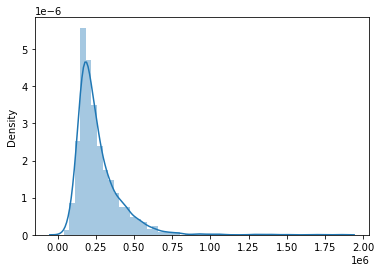

[Row(skewness(LISTPRICE)=2.790448093916559)]


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
# Select a single column and sample and convert to pandas
sample_df = df.select(['LISTPRICE']).sample( False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)
plt.show()

# Import skewness function
from pyspark.sql.functions import skewness

# Compute and print skewness of LISTPRICE
print(df.agg({'LISTPRICE': 'skewness'}).collect())

# Using Visualizations: lmplot

Creating linear model plots helps us visualize if variables have relationships with the dependent variable. If they do they are good candidates to include in our analysis. If they don't it doesn't mean that we should throw them out, it means we may have to process or wrangle them before they can be used.

In [16]:
df = df.withColumn("SalesClosePrice", df.SalesClosePrice.cast("bigint"))
df = df.withColumn("LivingArea", df.LivingArea.cast("bigint"))
df.select(['SalesClosePrice', 'LivingArea']).dtypes


[('SalesClosePrice', 'bigint'), ('LivingArea', 'bigint')]

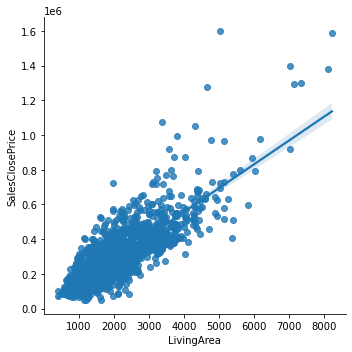

In [17]:
# Select a the relevant columns and sample
sample_df = df.select(['SalesClosePrice', 'LivingArea']).sample(False, 0.5, 42)

# Convert to pandas dataframe
pandas_df = sample_df.toPandas()

# Linear model plot of pandas_df
sns.lmplot(x='LivingArea', y='SalesClosePrice', data=pandas_df)
plt.show()